In [1]:
#!pip install catboost
#!pip install optuna

## Импорт необходимых библиотек

In [ ]:
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OrdinalEncoder
import ast
import json
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import seaborn as sns
import shap

f:\VK_Predict\Hackathon_urfu_vk\venv1\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Загрузка данных

In [4]:
geo_info = pd.read_csv('D:\Downloads\\VK data\\geo_info.csv', delimiter=';')
referer_vectors = pd.read_csv('D:\Downloads\\VK data\\referer_vectors.csv', delimiter=';')
test_users = pd.read_csv('D:\Downloads\\VK data\\test_users.csv', delimiter=';')
test = pd.read_csv('D:\Downloads\\VK data\\test.csv', delimiter=';')
train = pd.read_csv('D:\Downloads\\VK data\\train.csv', delimiter=';')
train_labels = pd.read_csv('D:\Downloads\\VK data\\train_labels.csv', delimiter=';')

In [5]:
train.head()

,request_ts,user_id,referer,geo_id,user_agent
0,1701011363,fb858e8e0a2bec074450eaf94b627fd3,https://9b48ee5/,4799,"{'browser': 'Chrome Mobile', 'browser_version'..."
1,1700986581,46a5f128fd569c764a92c2eaa788095e,https://9b48ee5/,8257,"{'browser': 'Chrome Mobile', 'browser_version'..."
2,1701011071,5a74e9ac53ffb21a20cce117c0ad77ba,https://9634fd0/1409e548,3150,"{'browser': 'Yandex Browser', 'browser_version..."
3,1700992803,af735816ca19115431ae3d89518c8c91,https://9b48ee5/,2740,"{'browser': 'Chrome Mobile', 'browser_version'..."
4,1701021666,364f0ae0a3f29a685c4fb5bae6033b9a,https://9b48ee5/,4863,"{'browser': 'Yandex Browser', 'browser_version..."


## Анализ и предобработка данных

In [6]:
train.isnull().sum()

request_ts    0
user_id       0
referer       0
geo_id        0
user_agent    1
dtype: int64

In [7]:
#Удалим пропущенные строки
train = train.dropna(subset = ['user_agent'])

In [8]:
train['user_agent'].nunique()

8432

In [9]:
#Преобразуем колонку user_agent
train['user_agent'] = train['user_agent'].apply(ast.literal_eval)
df_exp = pd.json_normalize(train['user_agent'])
train = pd.concat([train, df_exp], axis = 1).drop(columns = ['user_agent'], axis = 1)

In [10]:
train.head()

,request_ts,user_id,referer,geo_id,browser,browser_version,os,os_version
0,1.701011e+09,fb858e8e0a2bec074450eaf94b627fd3,https://9b48ee5/,4799.0,Chrome Mobile,119.0.0,Android,10
1,1.700987e+09,46a5f128fd569c764a92c2eaa788095e,https://9b48ee5/,8257.0,Chrome Mobile,111.0.0,Android,10
2,1.701011e+09,5a74e9ac53ffb21a20cce117c0ad77ba,https://9634fd0/1409e548,3150.0,Yandex Browser,20.12.5,Android,11
3,1.700993e+09,af735816ca19115431ae3d89518c8c91,https://9b48ee5/,2740.0,Chrome Mobile,119.0.0,Android,10
4,1.701022e+09,364f0ae0a3f29a685c4fb5bae6033b9a,https://9b48ee5/,4863.0,Yandex Browser,18.11.1,Android,4.4.4


In [11]:
train['request_ts'].nunique()

85501

In [12]:
train.head()

,request_ts,user_id,referer,geo_id,browser,browser_version,os,os_version
0,1.701011e+09,fb858e8e0a2bec074450eaf94b627fd3,https://9b48ee5/,4799.0,Chrome Mobile,119.0.0,Android,10
1,1.700987e+09,46a5f128fd569c764a92c2eaa788095e,https://9b48ee5/,8257.0,Chrome Mobile,111.0.0,Android,10
2,1.701011e+09,5a74e9ac53ffb21a20cce117c0ad77ba,https://9634fd0/1409e548,3150.0,Yandex Browser,20.12.5,Android,11
3,1.700993e+09,af735816ca19115431ae3d89518c8c91,https://9b48ee5/,2740.0,Chrome Mobile,119.0.0,Android,10
4,1.701022e+09,364f0ae0a3f29a685c4fb5bae6033b9a,https://9b48ee5/,4863.0,Yandex Browser,18.11.1,Android,4.4.4


In [13]:
train.isnull().sum()

request_ts         1
user_id            1
referer            1
geo_id             1
browser            1
browser_version    1
os                 1
os_version         1
dtype: int64

In [14]:
#Удалим пропущенные значения
train = train.dropna(subset = ['user_id', 'referer', 'geo_id', 'os'])

In [15]:
train.isnull().sum()

request_ts         0
user_id            0
referer            0
geo_id             0
browser            0
browser_version    0
os                 0
os_version         0
dtype: int64

In [16]:
#Проверим на пропущенные значения тестовый датасет
test.isnull().sum()

request_ts    0
user_id       0
referer       0
geo_id        0
user_agent    0
dtype: int64

In [17]:
test['user_agent'] = test['user_agent'].apply(ast.literal_eval)
df_exp_test = pd.json_normalize(test['user_agent'])
test = pd.concat([test, df_exp_test], axis = 1).drop(columns = ['user_agent'], axis = 1)

In [18]:
test.head()

,request_ts,user_id,referer,geo_id,browser,browser_version,os,os_version
0,1700993094,c2802dadd33d8ae09bb366bdd41212ea,https://9b48ee5/,8816,Chrome Mobile,96.0.4664,Android,12
1,1701005579,e5b1988db74527ec092f28b0bbfdaac9,https://9b48ee5/,3663,Chrome,116.0.5845,Android,10
2,1700969752,6ef1eedbdb72554e53e69782066065c5,https://72879b4/12411b9e,2336,Chrome,114.0.0,Android,10
3,1700991608,7e057293ecae62985a327b7af51858ea,https://9b48ee5/,9652,Chrome Mobile,91.0.4472,Android,11
4,1701019815,a27bd7ce8828497823fa8d5d05e7bbf7,https://9b48ee5/,3871,Chrome Mobile,119.0.0,Android,10


In [19]:
print('region_id', geo_info['region_id'].nunique())
print('country_id', geo_info['country_id'].nunique())
print('timezone_id', geo_info['timezone_id'].nunique())
print('geo_id', geo_info['geo_id'].nunique())

region_id 277
country_id 203
timezone_id 314
geo_id 5533


In [20]:
geo_info.isnull().sum()

geo_id            0
country_id        0
region_id      1707
timezone_id       0
dtype: int64

In [21]:
geo_info['region_id'] = geo_info['region_id'].fillna('Unknown')

In [22]:
train_with_geo = pd.merge(train, geo_info, on = 'geo_id', how = 'inner')
train_with_geo.isnull().sum()

request_ts         0
user_id            0
referer            0
geo_id             0
browser            0
browser_version    0
os                 0
os_version         0
country_id         0
region_id          0
timezone_id        0
dtype: int64

In [23]:
test_with_geo = pd.merge(test, geo_info, on = 'geo_id', how = 'inner')
test_with_geo.isnull().sum()

request_ts         0
user_id            0
referer            0
geo_id             0
browser            0
browser_version    0
os                 0
os_version         0
country_id         0
region_id          0
timezone_id        0
dtype: int64

In [24]:
train_with_geo.head()

,request_ts,user_id,referer,geo_id,browser,browser_version,os,os_version,country_id,region_id,timezone_id
0,1.701011e+09,fb858e8e0a2bec074450eaf94b627fd3,https://9b48ee5/,4799.0,Chrome Mobile,119.0.0,Android,10,c31b4e,470e75,f6155e
1,1.700987e+09,46a5f128fd569c764a92c2eaa788095e,https://9b48ee5/,8257.0,Chrome Mobile,111.0.0,Android,10,c31b4e,44520b,e56e80
2,1.701011e+09,5a74e9ac53ffb21a20cce117c0ad77ba,https://9634fd0/1409e548,3150.0,Yandex Browser,20.12.5,Android,11,c31b4e,616bb9,af47f1
3,1.700993e+09,af735816ca19115431ae3d89518c8c91,https://9b48ee5/,2740.0,Chrome Mobile,119.0.0,Android,10,c31b4e,3c9dca,e56e80
4,1.701022e+09,364f0ae0a3f29a685c4fb5bae6033b9a,https://9b48ee5/,4863.0,Yandex Browser,18.11.1,Android,4.4.4,c31b4e,776e76,10b7947


In [25]:
train_geo_labels = pd.merge(train_with_geo, train_labels, on='user_id', how='inner')

In [26]:
train_geo_labels.isnull().sum()

request_ts         0
user_id            0
referer            0
geo_id             0
browser            0
browser_version    0
os                 0
os_version         0
country_id         0
region_id          0
timezone_id        0
target             0
dtype: int64

In [27]:
train_geo_labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 593442 entries, 0 to 593441
Data columns (total 12 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   request_ts       593442 non-null  float64
 1   user_id          593442 non-null  object 
 2   referer          593442 non-null  object 
 3   geo_id           593442 non-null  float64
 4   browser          593442 non-null  object 
 5   browser_version  593442 non-null  object 
 6   os               593442 non-null  object 
 7   os_version       593442 non-null  object 
 8   country_id       593442 non-null  object 
 9   region_id        593442 non-null  object 
 10  timezone_id      593442 non-null  object 
 11  target           593442 non-null  int64  
dtypes: float64(2), int64(1), object(9)
memory usage: 54.3+ MB


In [28]:
referer_vectors.head()

,component0,component1,component2,component3,component4,component5,component6,component7,component8,component9,referer
0,16708,-3741,11395,-1597,-3212,6269,5610,-15351,13779,14102,https://a6899a4/15652e67
1,11731,4045,22213,-1184,-8992,9381,-3496,-3120,-899,16817,https://9b48ee5/
2,10551,2947,12282,-470,16222,4472,-3316,9606,4197,18948,https://7a4c700/161af7e3
3,12816,20498,-10110,7731,-569,12035,3014,6398,11439,-271,https://9653126/159bc361
4,3710,11096,11333,14673,8030,1852,10554,11625,4306,13210,https://72879b4/125c29e6


In [29]:
referer_vectors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 11 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   component0  200000 non-null  int64 
 1   component1  200000 non-null  int64 
 2   component2  200000 non-null  int64 
 3   component3  200000 non-null  int64 
 4   component4  200000 non-null  int64 
 5   component5  200000 non-null  int64 
 6   component6  200000 non-null  int64 
 7   component7  200000 non-null  int64 
 8   component8  200000 non-null  int64 
 9   component9  200000 non-null  int64 
 10  referer     200000 non-null  object
dtypes: int64(10), object(1)
memory usage: 16.8+ MB


In [30]:
full_train = pd.merge(train_geo_labels, referer_vectors, on='referer', how="inner")

In [31]:
full_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 601289 entries, 0 to 601288
Data columns (total 22 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   request_ts       601289 non-null  float64
 1   user_id          601289 non-null  object 
 2   referer          601289 non-null  object 
 3   geo_id           601289 non-null  float64
 4   browser          601289 non-null  object 
 5   browser_version  601289 non-null  object 
 6   os               601289 non-null  object 
 7   os_version       601289 non-null  object 
 8   country_id       601289 non-null  object 
 9   region_id        601289 non-null  object 
 10  timezone_id      601289 non-null  object 
 11  target           601289 non-null  int64  
 12  component0       601289 non-null  int64  
 13  component1       601289 non-null  int64  
 14  component2       601289 non-null  int64  
 15  component3       601289 non-null  int64  
 16  component4       601289 non-null  int6

In [32]:
full_train.isnull().sum()

request_ts         0
user_id            0
referer            0
geo_id             0
browser            0
browser_version    0
os                 0
os_version         0
country_id         0
region_id          0
timezone_id        0
target             0
component0         0
component1         0
component2         0
component3         0
component4         0
component5         0
component6         0
component7         0
component8         0
component9         0
dtype: int64

In [33]:
full_train.head()

,request_ts,user_id,referer,geo_id,browser,browser_version,os,os_version,country_id,region_id,...,component0,component1,component2,component3,component4,component5,component6,component7,component8,component9
0,1.701011e+09,fb858e8e0a2bec074450eaf94b627fd3,https://9b48ee5/,4799.0,Chrome Mobile,119.0.0,Android,10,c31b4e,470e75,...,11731,4045,22213,-1184,-8992,9381,-3496,-3120,-899,16817
1,1.700987e+09,46a5f128fd569c764a92c2eaa788095e,https://9b48ee5/,8257.0,Chrome Mobile,111.0.0,Android,10,c31b4e,44520b,...,11731,4045,22213,-1184,-8992,9381,-3496,-3120,-899,16817
2,1.701011e+09,5a74e9ac53ffb21a20cce117c0ad77ba,https://9634fd0/1409e548,3150.0,Yandex Browser,20.12.5,Android,11,c31b4e,616bb9,...,12498,2451,10304,-6380,11608,3106,-2188,10573,3347,21870
3,1.700993e+09,af735816ca19115431ae3d89518c8c91,https://9b48ee5/,2740.0,Chrome Mobile,119.0.0,Android,10,c31b4e,3c9dca,...,11731,4045,22213,-1184,-8992,9381,-3496,-3120,-899,16817
4,1.701022e+09,364f0ae0a3f29a685c4fb5bae6033b9a,https://9b48ee5/,4863.0,Yandex Browser,18.11.1,Android,4.4.4,c31b4e,776e76,...,11731,4045,22213,-1184,-8992,9381,-3496,-3120,-899,16817


In [34]:
for i in  full_train.columns:
    print(i, full_train[i].nunique())

request_ts 84730
user_id 499999
referer 135012
geo_id 2828
browser 59
browser_version 1437
os 13
os_version 230
country_id 151
region_id 259
timezone_id 218
target 2
component0 27196
component1 31467
component2 26412
component3 30622
component4 30426
component5 26702
component6 27506
component7 28597
component8 28248
component9 36867


In [35]:
#Удалим те колонки, которые не повляют на качество модели
full_train = full_train.drop(['referer', 'geo_id'], axis = 1)

In [36]:
full_train = full_train.drop(['user_id'], axis = 1)

In [37]:
full_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 601289 entries, 0 to 601288
Data columns (total 19 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   request_ts       601289 non-null  float64
 1   browser          601289 non-null  object 
 2   browser_version  601289 non-null  object 
 3   os               601289 non-null  object 
 4   os_version       601289 non-null  object 
 5   country_id       601289 non-null  object 
 6   region_id        601289 non-null  object 
 7   timezone_id      601289 non-null  object 
 8   target           601289 non-null  int64  
 9   component0       601289 non-null  int64  
 10  component1       601289 non-null  int64  
 11  component2       601289 non-null  int64  
 12  component3       601289 non-null  int64  
 13  component4       601289 non-null  int64  
 14  component5       601289 non-null  int64  
 15  component6       601289 non-null  int64  
 16  component7       601289 non-null  int6

In [38]:
full_train.head()

,request_ts,browser,browser_version,os,os_version,country_id,region_id,timezone_id,target,component0,component1,component2,component3,component4,component5,component6,component7,component8,component9
0,1.701011e+09,Chrome Mobile,119.0.0,Android,10,c31b4e,470e75,f6155e,0,11731,4045,22213,-1184,-8992,9381,-3496,-3120,-899,16817
1,1.700987e+09,Chrome Mobile,111.0.0,Android,10,c31b4e,44520b,e56e80,0,11731,4045,22213,-1184,-8992,9381,-3496,-3120,-899,16817
2,1.701011e+09,Yandex Browser,20.12.5,Android,11,c31b4e,616bb9,af47f1,0,12498,2451,10304,-6380,11608,3106,-2188,10573,3347,21870
3,1.700993e+09,Chrome Mobile,119.0.0,Android,10,c31b4e,3c9dca,e56e80,0,11731,4045,22213,-1184,-8992,9381,-3496,-3120,-899,16817
4,1.701022e+09,Yandex Browser,18.11.1,Android,4.4.4,c31b4e,776e76,10b7947,0,11731,4045,22213,-1184,-8992,9381,-3496,-3120,-899,16817


In [39]:
#Попробуем также удалить колонки browser_version, os_version в связи с неспособностью нормально их представить в связи с большим количеством различных значений
full_train = full_train.drop(['browser_version', 'os_version'], axis=1)

In [40]:
full_train.head()

,request_ts,browser,os,country_id,region_id,timezone_id,target,component0,component1,component2,component3,component4,component5,component6,component7,component8,component9
0,1.701011e+09,Chrome Mobile,Android,c31b4e,470e75,f6155e,0,11731,4045,22213,-1184,-8992,9381,-3496,-3120,-899,16817
1,1.700987e+09,Chrome Mobile,Android,c31b4e,44520b,e56e80,0,11731,4045,22213,-1184,-8992,9381,-3496,-3120,-899,16817
2,1.701011e+09,Yandex Browser,Android,c31b4e,616bb9,af47f1,0,12498,2451,10304,-6380,11608,3106,-2188,10573,3347,21870
3,1.700993e+09,Chrome Mobile,Android,c31b4e,3c9dca,e56e80,0,11731,4045,22213,-1184,-8992,9381,-3496,-3120,-899,16817
4,1.701022e+09,Yandex Browser,Android,c31b4e,776e76,10b7947,0,11731,4045,22213,-1184,-8992,9381,-3496,-3120,-899,16817


In [41]:
full_train['target'] = full_train['target'].astype('category')

In [42]:
full_train.isnull().sum()

request_ts     0
browser        0
os             0
country_id     0
region_id      0
timezone_id    0
target         0
component0     0
component1     0
component2     0
component3     0
component4     0
component5     0
component6     0
component7     0
component8     0
component9     0
dtype: int64

In [43]:
# Преобразование request_ts в datetime
full_train['request_ts'] = pd.to_datetime(full_train['request_ts'], unit='s')

# Извлечение дополнительных признаков
full_train['day_of_week'] = full_train['request_ts'].dt.day_name()  # День недели (например, 'Monday')
full_train['hour'] = full_train['request_ts'].dt.hour             # Час дня
full_train['month'] = full_train['request_ts'].dt.month           # Номер месяца
full_train['day'] = full_train['request_ts'].dt.day               # День месяца
full_train['year'] = full_train['request_ts'].dt.year

In [44]:
full_train.head()

,request_ts,browser,os,country_id,region_id,timezone_id,target,component0,component1,component2,...,component5,component6,component7,component8,component9,day_of_week,hour,month,day,year
0,2023-11-26 15:09:23,Chrome Mobile,Android,c31b4e,470e75,f6155e,0,11731,4045,22213,...,9381,-3496,-3120,-899,16817,Sunday,15,11,26,2023
1,2023-11-26 08:16:21,Chrome Mobile,Android,c31b4e,44520b,e56e80,0,11731,4045,22213,...,9381,-3496,-3120,-899,16817,Sunday,8,11,26,2023
2,2023-11-26 15:04:31,Yandex Browser,Android,c31b4e,616bb9,af47f1,0,12498,2451,10304,...,3106,-2188,10573,3347,21870,Sunday,15,11,26,2023
3,2023-11-26 10:00:03,Chrome Mobile,Android,c31b4e,3c9dca,e56e80,0,11731,4045,22213,...,9381,-3496,-3120,-899,16817,Sunday,10,11,26,2023
4,2023-11-26 18:01:06,Yandex Browser,Android,c31b4e,776e76,10b7947,0,11731,4045,22213,...,9381,-3496,-3120,-899,16817,Sunday,18,11,26,2023


In [45]:
#Удалим лишние признаки
full_train = full_train.drop(['request_ts', 'browser', 'os'], axis=1)

In [46]:
full_train.head()

,country_id,region_id,timezone_id,target,component0,component1,component2,component3,component4,component5,component6,component7,component8,component9,day_of_week,hour,month,day,year
0,c31b4e,470e75,f6155e,0,11731,4045,22213,-1184,-8992,9381,-3496,-3120,-899,16817,Sunday,15,11,26,2023
1,c31b4e,44520b,e56e80,0,11731,4045,22213,-1184,-8992,9381,-3496,-3120,-899,16817,Sunday,8,11,26,2023
2,c31b4e,616bb9,af47f1,0,12498,2451,10304,-6380,11608,3106,-2188,10573,3347,21870,Sunday,15,11,26,2023
3,c31b4e,3c9dca,e56e80,0,11731,4045,22213,-1184,-8992,9381,-3496,-3120,-899,16817,Sunday,10,11,26,2023
4,c31b4e,776e76,10b7947,0,11731,4045,22213,-1184,-8992,9381,-3496,-3120,-899,16817,Sunday,18,11,26,2023


In [51]:
# Определение колонок для кодирования
columns_to_encode = ['country_id', 'region_id', 'timezone_id' ]

# Инициализация LabelEncoder
label_encoders = {}

# Кодирование каждой колонки
for column in columns_to_encode:
    le = LabelEncoder()
    full_train[column] = le.fit_transform(full_train[column])
     # Сохраняем энкодер в словарь для будущего использования
    label_encoders[column] = le

In [52]:
# Инициализация OrdinalEncoder с порядком дней недели
ord_encoder = OrdinalEncoder(categories=[['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']])

# Применяем Ordinal Encoding
full_train['day_of_week'] = ord_encoder.fit_transform(full_train[['day_of_week']])

## EDA полного тренировочного датасета

In [53]:
full_train.head()

,country_id,region_id,timezone_id,target,component0,component1,component2,component3,component4,component5,component6,component7,component8,component9,day_of_week,hour,month,day,year
0,103,116,205,0,11731,4045,22213,-1184,-8992,9381,-3496,-3120,-899,16817,6.0,15,11,26,2023
1,103,111,179,0,11731,4045,22213,-1184,-8992,9381,-3496,-3120,-899,16817,6.0,8,11,26,2023
2,103,160,96,0,12498,2451,10304,-6380,11608,3106,-2188,10573,3347,21870,6.0,15,11,26,2023
3,103,99,179,0,11731,4045,22213,-1184,-8992,9381,-3496,-3120,-899,16817,6.0,10,11,26,2023
4,103,200,22,0,11731,4045,22213,-1184,-8992,9381,-3496,-3120,-899,16817,6.0,18,11,26,2023


In [54]:
#Проверим размерность полного тренировочного датасета
full_train.shape

(601289, 19)

In [55]:
#Посмотрим типы данных для каждого столбца
full_train.dtypes

country_id        int32
region_id         int32
timezone_id       int32
target         category
component0        int64
component1        int64
component2        int64
component3        int64
component4        int64
component5        int64
component6        int64
component7        int64
component8        int64
component9        int64
day_of_week     float64
hour              int32
month             int32
day               int32
year              int32
dtype: object

In [56]:
#Проверим пропущенные значения
full_train.isnull().sum()

country_id     0
region_id      0
timezone_id    0
target         0
component0     0
component1     0
component2     0
component3     0
component4     0
component5     0
component6     0
component7     0
component8     0
component9     0
day_of_week    0
hour           0
month          0
day            0
year           0
dtype: int64

target
0    313572
1    287717
Name: count, dtype: int64


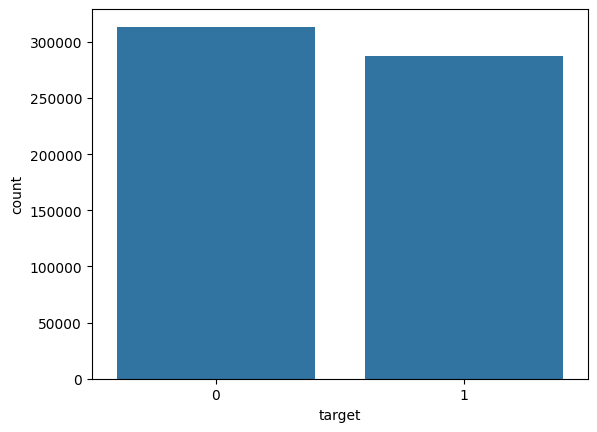

In [58]:
#Посмотрим на распределение целевой переменной
print(full_train['target'].value_counts())
sns.countplot(x='target', data=full_train)
plt.show()

In [57]:
# Вычисляем корреляционную матрицу
correlation_matrix = full_train.corr()

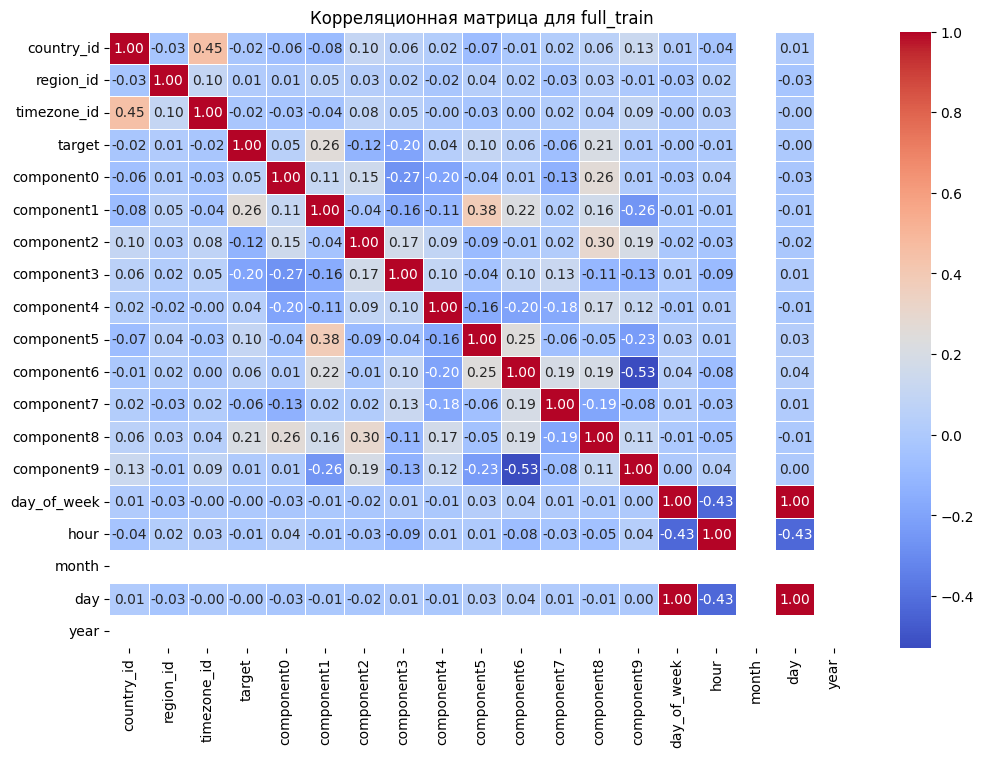

In [59]:
# Настройка размера графика
plt.figure(figsize=(12, 8))

# Построение тепловой карты
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)

# Отображение графика
plt.title('Корреляционная матрица для full_train')
plt.show()

## Обучение модели

[I 2024-12-18 17:49:39,671] A new study created in memory with name: no-name-43536cbd-7c22-4971-baa9-e9d54c82a744
[I 2024-12-18 17:49:59,671] Trial 0 finished with value: 0.7789892431630555 and parameters: {'learning_rate': 0.07614796664884885, 'iterations': 498, 'depth': 7, 'l2_leaf_reg': 9.143657765534163}. Best is trial 0 with value: 0.7789892431630555.
[I 2024-12-18 17:50:03,394] Trial 1 finished with value: 0.7275533351516401 and parameters: {'learning_rate': 0.02242025730880804, 'iterations': 159, 'depth': 4, 'l2_leaf_reg': 3.602327449752856}. Best is trial 0 with value: 0.7789892431630555.
[I 2024-12-18 17:50:15,468] Trial 2 finished with value: 0.7456610099585559 and parameters: {'learning_rate': 0.010595560990535479, 'iterations': 242, 'depth': 8, 'l2_leaf_reg': 1.3229417737393698}. Best is trial 0 with value: 0.7789892431630555.
[I 2024-12-18 17:50:28,632] Trial 3 finished with value: 0.7684718905290607 and parameters: {'learning_rate': 0.08085434449470638, 'iterations': 406,

Лучшие гиперпараметры: {'learning_rate': 0.07239963185302065, 'iterations': 474, 'depth': 10, 'l2_leaf_reg': 9.902214454141717}
Лучшее значение точности: 0.7876040259973524
Точность модели: 0.7876040259973524
              precision    recall  f1-score   support

           0       0.80      0.79      0.79     78305
           1       0.77      0.79      0.78     72018

    accuracy                           0.79    150323
   macro avg       0.79      0.79      0.79    150323
weighted avg       0.79      0.79      0.79    150323



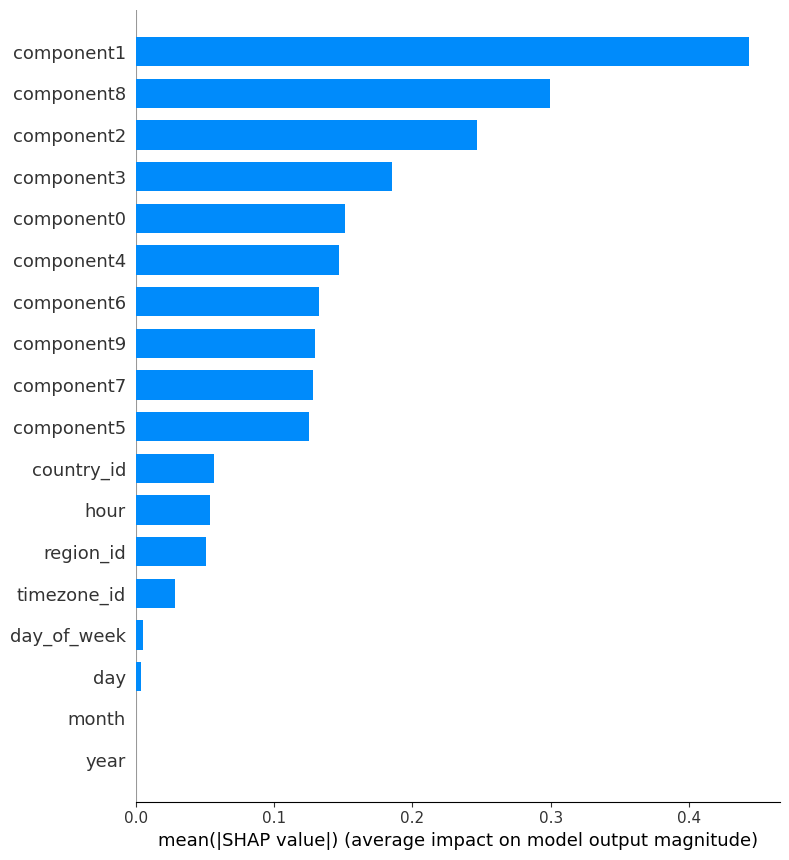

Важность признаков (SHAP):
        Feature  Importance
4    component1    0.443553
11   component8    0.299143
5    component2    0.246493
6    component3    0.184957
3    component0    0.151607
7    component4    0.147116
9    component6    0.132362
12   component9    0.129271
10   component7    0.128270
8    component5    0.125163
0    country_id    0.056799
14         hour    0.053929
1     region_id    0.050629
2   timezone_id    0.028239
13  day_of_week    0.005591
16          day    0.003830
15        month    0.000000
17         year    0.000000


In [60]:
# Разделение данных на признаки и целевую переменную
X = full_train.drop(['target'], axis=1)
y = full_train['target']

# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

scaler = StandardScaler()
scaler.fit(X_train)
scaled_X_train = scaler.transform(X_train)
scaled_X_test = scaler.transform(X_test)

# Определение функции для оптимизации гиперпараметров с использованием Optuna
def objective(trial):
    # Определение гиперпараметров для CatBoostClassifier
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.1, log=True)
    iterations = trial.suggest_int('iterations', 100, 500)
    depth = trial.suggest_int('depth', 4, 10)
    l2_leaf_reg = trial.suggest_float('l2_leaf_reg', 1, 10, log=True)

    # Инициализация CatBoostClassifier с гиперпараметрами
    model = CatBoostClassifier(
        learning_rate=learning_rate,
        iterations=iterations,
        depth=depth,
        l2_leaf_reg=l2_leaf_reg,
        eval_metric='Accuracy',
        verbose=0,
        random_state=42
    )

    # Обучение модели на обучающей выборке
    model.fit(X_train, y_train)

    # Предсказание на тестовой выборке
    y_preds = model.predict(X_test)

    # Оценка точности модели
    accuracy = accuracy_score(y_test, y_preds)
    return accuracy

# Создание и запуск Optuna для поиска наилучших гиперпараметров
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Вывод лучших гиперпараметров и точности
print("Лучшие гиперпараметры:", study.best_params)
print("Лучшее значение точности:", study.best_value)

# Обучение модели с оптимальными гиперпараметрами
best_params = study.best_params
model = CatBoostClassifier(
    learning_rate=best_params['learning_rate'],
    iterations=best_params['iterations'],
    depth=best_params['depth'],
    l2_leaf_reg=best_params['l2_leaf_reg'],
    eval_metric='Accuracy',
    verbose=0,
    random_state=42
)

# Обучение модели на обучающей выборке с лучшими гиперпараметрами
model.fit(X_train, y_train)

# Предсказание на тестовой выборке
y_preds = model.predict(X_test)

# Оценка точности модели
accuracy = accuracy_score(y_test, y_preds)
print("Точность модели:", accuracy)

# Вывод отчета о классификации
print(classification_report(y_test, y_preds))

# SHAP-анализ
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

# Визуализация SHAP-значений
shap.summary_plot(shap_values, X_test, plot_type="bar")

# Вывод важности признаков в текстовом виде
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': np.abs(shap_values).mean(axis=0)
})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)
print("Важность признаков (SHAP):")
print(feature_importances)

In [61]:
#Попробуем удалить наименее важные признаки и обучить модель еще раз
full_train = full_train.drop(['timezone_id', 'day_of_week', 'day', 'month', 'year'], axis=1)

In [62]:
full_train.head()

,country_id,region_id,target,component0,component1,component2,component3,component4,component5,component6,component7,component8,component9,hour
0,103,116,0,11731,4045,22213,-1184,-8992,9381,-3496,-3120,-899,16817,15
1,103,111,0,11731,4045,22213,-1184,-8992,9381,-3496,-3120,-899,16817,8
2,103,160,0,12498,2451,10304,-6380,11608,3106,-2188,10573,3347,21870,15
3,103,99,0,11731,4045,22213,-1184,-8992,9381,-3496,-3120,-899,16817,10
4,103,200,0,11731,4045,22213,-1184,-8992,9381,-3496,-3120,-899,16817,18


[I 2024-12-18 18:11:07,416] A new study created in memory with name: no-name-ae85cc4c-896c-4362-9222-23ea9cf98380
[I 2024-12-18 18:11:19,053] Trial 0 finished with value: 0.7717381904299409 and parameters: {'learning_rate': 0.04822997642473153, 'iterations': 275, 'depth': 8, 'l2_leaf_reg': 9.907911951276198}. Best is trial 0 with value: 0.7717381904299409.
[I 2024-12-18 18:11:31,266] Trial 1 finished with value: 0.770733686794436 and parameters: {'learning_rate': 0.06665418371343147, 'iterations': 371, 'depth': 6, 'l2_leaf_reg': 9.713084398745158}. Best is trial 0 with value: 0.7717381904299409.
[I 2024-12-18 18:11:47,206] Trial 2 finished with value: 0.7733613618674454 and parameters: {'learning_rate': 0.050424628589559255, 'iterations': 431, 'depth': 7, 'l2_leaf_reg': 3.227103410123839}. Best is trial 2 with value: 0.7733613618674454.
[I 2024-12-18 18:12:03,980] Trial 3 finished with value: 0.7599835021919467 and parameters: {'learning_rate': 0.021334134168118794, 'iterations': 462, 

Лучшие гиперпараметры: {'learning_rate': 0.09835156456733304, 'iterations': 446, 'depth': 10, 'l2_leaf_reg': 9.985843975682318}
Лучшее значение точности: 0.7885885726069863
Точность модели: 0.7885885726069863
              precision    recall  f1-score   support

           0       0.80      0.79      0.79     78305
           1       0.77      0.79      0.78     72018

    accuracy                           0.79    150323
   macro avg       0.79      0.79      0.79    150323
weighted avg       0.79      0.79      0.79    150323



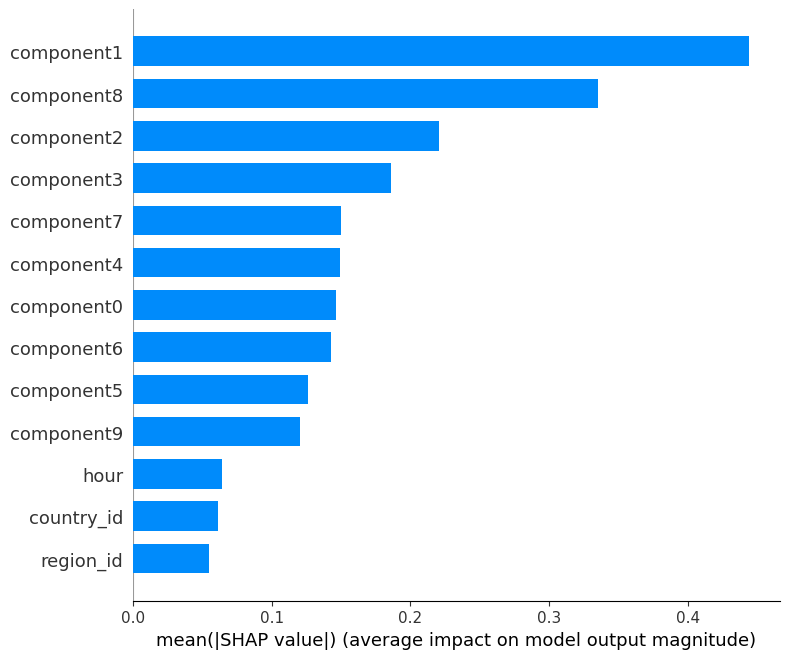

Важность признаков (SHAP):
       Feature  Importance
3   component1    0.444164
10  component8    0.334830
4   component2    0.220574
5   component3    0.186006
9   component7    0.149730
6   component4    0.149020
2   component0    0.146437
8   component6    0.142860
7   component5    0.126358
11  component9    0.120198
12        hour    0.064059
0   country_id    0.061310
1    region_id    0.055127


In [63]:
# Разделение данных на признаки и целевую переменную
X = full_train.drop(['target'], axis=1)
y = full_train['target']

# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

scaler = StandardScaler()
scaler.fit(X_train)
scaled_X_train = scaler.transform(X_train)
scaled_X_test = scaler.transform(X_test)

# Определение функции для оптимизации гиперпараметров с использованием Optuna
def objective(trial):
    # Определение гиперпараметров для CatBoostClassifier
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.1, log=True)
    iterations = trial.suggest_int('iterations', 100, 500)
    depth = trial.suggest_int('depth', 4, 10)
    l2_leaf_reg = trial.suggest_float('l2_leaf_reg', 1, 10, log=True)

    # Инициализация CatBoostClassifier с гиперпараметрами
    model_v2 = CatBoostClassifier(
        learning_rate=learning_rate,
        iterations=iterations,
        depth=depth,
        l2_leaf_reg=l2_leaf_reg,
        eval_metric='Accuracy',
        verbose=0,
        random_state=42
    )

    # Обучение модели на обучающей выборке
    model_v2.fit(X_train, y_train)

    # Предсказание на тестовой выборке
    y_preds = model_v2.predict(X_test)

    # Оценка точности модели
    accuracy = accuracy_score(y_test, y_preds)
    return accuracy

# Создание и запуск Optuna для поиска наилучших гиперпараметров
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Вывод лучших гиперпараметров и точности
print("Лучшие гиперпараметры:", study.best_params)
print("Лучшее значение точности:", study.best_value)

# Обучение модели с оптимальными гиперпараметрами
best_params = study.best_params
model_v2 = CatBoostClassifier(
    learning_rate=best_params['learning_rate'],
    iterations=best_params['iterations'],
    depth=best_params['depth'],
    l2_leaf_reg=best_params['l2_leaf_reg'],
    eval_metric='Accuracy',
    verbose=0,
    random_state=42
)

# Обучение модели на обучающей выборке с лучшими гиперпараметрами
model_v2.fit(X_train, y_train)

# Предсказание на тестовой выборке
y_preds = model_v2.predict(X_test)

# Оценка точности модели
accuracy = accuracy_score(y_test, y_preds)
print("Точность модели:", accuracy)

# Вывод отчета о классификации
print(classification_report(y_test, y_preds))

# SHAP-анализ
explainer = shap.TreeExplainer(model_v2)
shap_values = explainer.shap_values(X_test)

# Визуализация SHAP-значений
shap.summary_plot(shap_values, X_test, plot_type="bar")

# Вывод важности признаков в текстовом виде
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': np.abs(shap_values).mean(axis=0)
})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)
print("Важность признаков (SHAP):")
print(feature_importances)

### Вывод: удаление наименее важных признаков не повлияло существенно на качество модели.

## Предобработка тестового датасета и предсказание пола каждого пользователя из файла test_users.csv

In [73]:
test.head()

,request_ts,user_id,referer,geo_id,browser,browser_version,os,os_version
0,1700993094,c2802dadd33d8ae09bb366bdd41212ea,https://9b48ee5/,8816,Chrome Mobile,96.0.4664,Android,12
1,1701005579,e5b1988db74527ec092f28b0bbfdaac9,https://9b48ee5/,3663,Chrome,116.0.5845,Android,10
2,1700969752,6ef1eedbdb72554e53e69782066065c5,https://72879b4/12411b9e,2336,Chrome,114.0.0,Android,10
3,1700991608,7e057293ecae62985a327b7af51858ea,https://9b48ee5/,9652,Chrome Mobile,91.0.4472,Android,11
4,1701019815,a27bd7ce8828497823fa8d5d05e7bbf7,https://9b48ee5/,3871,Chrome Mobile,119.0.0,Android,10


In [64]:
test_with_geo = pd.merge(test, geo_info, on='geo_id', how='inner')

In [65]:
test_with_geo.head()

,request_ts,user_id,referer,geo_id,browser,browser_version,os,os_version,country_id,region_id,timezone_id
0,1700993094,c2802dadd33d8ae09bb366bdd41212ea,https://9b48ee5/,8816,Chrome Mobile,96.0.4664,Android,12,c31b4e,36e3f3,f6155e
1,1701005579,e5b1988db74527ec092f28b0bbfdaac9,https://9b48ee5/,3663,Chrome,116.0.5845,Android,10,c31b4e,8ccc01,e56e80
2,1700969752,6ef1eedbdb72554e53e69782066065c5,https://72879b4/12411b9e,2336,Chrome,114.0.0,Android,10,c31b4e,1fbfa5,e56e80
3,1700991608,7e057293ecae62985a327b7af51858ea,https://9b48ee5/,9652,Chrome Mobile,91.0.4472,Android,11,c31b4e,f66ff,f6155e
4,1701019815,a27bd7ce8828497823fa8d5d05e7bbf7,https://9b48ee5/,3871,Chrome Mobile,119.0.0,Android,10,c31b4e,245864,e56e80


In [66]:
full_test = pd.merge(test_with_geo, referer_vectors, on='referer', how="inner")

In [67]:
full_test.isnull().sum()

request_ts         0
user_id            0
referer            0
geo_id             0
browser            0
browser_version    0
os                 0
os_version         0
country_id         0
region_id          0
timezone_id        0
component0         0
component1         0
component2         0
component3         0
component4         0
component5         0
component6         0
component7         0
component8         0
component9         0
dtype: int64

In [68]:
# Преобразование request_ts в datetime
full_test['request_ts'] = pd.to_datetime(full_test['request_ts'], unit='s')

# Извлечение дополнительных признаков
full_test['day_of_week'] = full_test['request_ts'].dt.day_name()  # День недели (например, 'Monday')
full_test['hour'] = full_test['request_ts'].dt.hour             # Час дня
full_test['month'] = full_test['request_ts'].dt.month           # Номер месяца
full_test['day'] = full_test['request_ts'].dt.day               # День месяца
full_test['year'] = full_test['request_ts'].dt.year

In [69]:
full_test.head()

,request_ts,user_id,referer,geo_id,browser,browser_version,os,os_version,country_id,region_id,...,component5,component6,component7,component8,component9,day_of_week,hour,month,day,year
0,2023-11-26 10:04:54,c2802dadd33d8ae09bb366bdd41212ea,https://9b48ee5/,8816,Chrome Mobile,96.0.4664,Android,12,c31b4e,36e3f3,...,9381,-3496,-3120,-899,16817,Sunday,10,11,26,2023
1,2023-11-26 13:32:59,e5b1988db74527ec092f28b0bbfdaac9,https://9b48ee5/,3663,Chrome,116.0.5845,Android,10,c31b4e,8ccc01,...,9381,-3496,-3120,-899,16817,Sunday,13,11,26,2023
2,2023-11-26 03:35:52,6ef1eedbdb72554e53e69782066065c5,https://72879b4/12411b9e,2336,Chrome,114.0.0,Android,10,c31b4e,1fbfa5,...,1200,10169,16461,-3932,3340,Sunday,3,11,26,2023
3,2023-11-26 09:40:08,7e057293ecae62985a327b7af51858ea,https://9b48ee5/,9652,Chrome Mobile,91.0.4472,Android,11,c31b4e,f66ff,...,9381,-3496,-3120,-899,16817,Sunday,9,11,26,2023
4,2023-11-26 17:30:15,a27bd7ce8828497823fa8d5d05e7bbf7,https://9b48ee5/,3871,Chrome Mobile,119.0.0,Android,10,c31b4e,245864,...,9381,-3496,-3120,-899,16817,Sunday,17,11,26,2023


In [70]:
users = full_test['user_id']

In [71]:
#Удалим ненужные колонки
full_test = full_test.drop(['geo_id', 'user_id', 'request_ts', 'referer', 'browser_version', 'os_version', 'browser', 'os', 'timezone_id', 'day_of_week', 'day', 'month', 'year'], axis = 1)

In [72]:
full_test.head()

,country_id,region_id,component0,component1,component2,component3,component4,component5,component6,component7,component8,component9,hour
0,c31b4e,36e3f3,11731,4045,22213,-1184,-8992,9381,-3496,-3120,-899,16817,10
1,c31b4e,8ccc01,11731,4045,22213,-1184,-8992,9381,-3496,-3120,-899,16817,13
2,c31b4e,1fbfa5,-7307,11682,9741,13564,13577,1200,10169,16461,-3932,3340,3
3,c31b4e,f66ff,11731,4045,22213,-1184,-8992,9381,-3496,-3120,-899,16817,9
4,c31b4e,245864,11731,4045,22213,-1184,-8992,9381,-3496,-3120,-899,16817,17


In [73]:
# Определение колонок для кодирования
columns_to_encode = ['country_id', 'region_id']

# Инициализация LabelEncoder
label_encoders = {}

# Кодирование каждой колонки
for column in columns_to_encode:
    le = LabelEncoder()
    full_test[column] = le.fit_transform(full_test[column])

In [74]:
full_test.head()

,country_id,region_id,component0,component1,component2,component3,component4,component5,component6,component7,component8,component9,hour
0,87,81,11731,4045,22213,-1184,-8992,9381,-3496,-3120,-899,16817,10
1,87,226,11731,4045,22213,-1184,-8992,9381,-3496,-3120,-899,16817,13
2,87,24,-7307,11682,9741,13564,13577,1200,10169,16461,-3932,3340,3
3,87,242,11731,4045,22213,-1184,-8992,9381,-3496,-3120,-899,16817,9
4,87,43,11731,4045,22213,-1184,-8992,9381,-3496,-3120,-899,16817,17


In [75]:
X = full_test

In [76]:
scaled_X_full_test = scaler.fit_transform(X)

In [77]:
y_preds = model_v2.predict(scaled_X_test)

In [78]:
finished_df = pd.concat([users, pd.DataFrame(y_preds)], axis=1)

In [79]:
finished_df.head()

,user_id,0
0,c2802dadd33d8ae09bb366bdd41212ea,1.0
1,e5b1988db74527ec092f28b0bbfdaac9,1.0
2,6ef1eedbdb72554e53e69782066065c5,0.0
3,7e057293ecae62985a327b7af51858ea,1.0
4,a27bd7ce8828497823fa8d5d05e7bbf7,1.0


In [80]:
finished_df_unique = finished_df[['user_id', 0]].drop_duplicates(subset=['user_id'])

In [81]:
answer = test_users.merge(finished_df_unique, on='user_id', how="left")

In [82]:
answer.isnull().sum()

user_id    0
0          0
dtype: int64

In [83]:
test_users.shape

(85000, 1)

In [84]:
answer.head()

,user_id,0
0,c2802dadd33d8ae09bb366bdd41212ea,1.0
1,e5b1988db74527ec092f28b0bbfdaac9,1.0
2,6ef1eedbdb72554e53e69782066065c5,0.0
3,7e057293ecae62985a327b7af51858ea,1.0
4,a27bd7ce8828497823fa8d5d05e7bbf7,1.0


In [85]:
answer[0] = answer[0].astype(int)

In [86]:
answer.rename(columns = {0:'target'}, inplace=True)

In [87]:
answer.head()

,user_id,target
0,c2802dadd33d8ae09bb366bdd41212ea,1
1,e5b1988db74527ec092f28b0bbfdaac9,1
2,6ef1eedbdb72554e53e69782066065c5,0
3,7e057293ecae62985a327b7af51858ea,1
4,a27bd7ce8828497823fa8d5d05e7bbf7,1


In [88]:
#Сохранение результатов предсказания
answer.to_csv('test_users_with_target.csv', index=False)